# Trabalho Completo de Processamento de Imagens


## 📌 1. Clusterização de Tons de Cinza
Em relação a técnica de transformação de tons de cinza baseado em clusterização, converta uma imagem colorida para tons de cinza e agrupe os tons de cinza a cada 4 grupos. Para exemplificar, dada uma imagem com 256 tons de cinza, aplicando agrupamento a cada 4 tons de cinza, a imagem resultante terá no máximo 64 tons de cinza.

Saving WILL.jpg to WILL.jpg


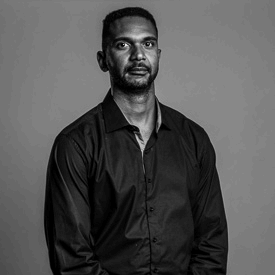

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

# Função que converte uma imagem colorida para tons de cinza
# e reduz a quantidade de tons agrupando-os em blocos (clusters).
def grayscale_cluster(img, group_size=4):
    # Converte a imagem de BGR (formato do OpenCV) para escala de cinza
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Agrupa os tons de cinza:
    # - Divide cada pixel pelo tamanho do grupo (ex: 4)
    # - Trunca o valor (divisão inteira)
    # - Multiplica novamente pelo grupo para "forçar" o pixel a pertencer ao cluster
    # Exemplo: pixel 153 → 153 // 4 = 38 → 38 * 4 = 152
    clustered = (gray // group_size) * group_size

    # Retorna a imagem com menos tons de cinza
    return clustered



## 📌 2. Subtração de Imagens para Detecção do Corpo
Aplicar a operação de subtração entre duas imagens para realçar a área do seu corpo presente em uma imagem. Primeiramente, escolha um local para obtenção das imagens. De preferência para uma cena que tenha uma parede no fundo com pouca variação de cor. Posicione a câmera em um local fixo, focando para a parede. A posição da câmera não deverá ser alterada para obter as duas imagens. O posicionamento da câmera deverá permitir o enquadramento do seu corpo inteiro ou parte do seu corpo. A primeira imagem obtida deverá apresentar apenas a parede (background), sem você.  A segunda imagem obtida deverá ser de você, com os braços abertos, tendo a parede como fundo. Após ter obtido as duas imagens, converta ambas para tons de cinza e aplique a subtração entre as mesmas. Depois disso, binarize a imagem utilizando um limiar determinado empiricamente, de modo a evidenciar a região na imagem onde seu corpo foi detectado. Plote um retângulo vermelho na área correspondente ao local da imagem onde o seu corpo foi identificado

Envie primeiro a imagem de BACKGROUND (sem pessoa):


Saving Background.jpg to Background (1).jpg
Envie agora a imagem da PESSOA:


Saving WILL.jpg to WILL (2).jpg
Diferença:


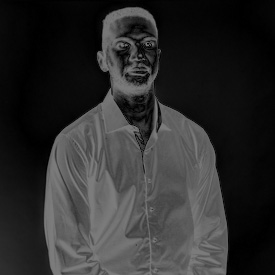

Imagem binária (threshold):


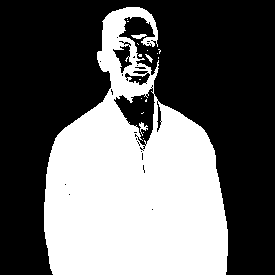

Máscara com contorno:


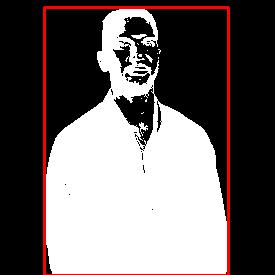

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

# Função para detectar o corpo pela técnica de subtração de imagens.
# 'bg' = imagem do fundo (sem a pessoa)
# 'person' = imagem com a pessoa
# 'thresh' = limiar para binarização
# 'min_area' = área mínima para considerar um contorno como corpo
def detectar_corpo(bg, person, thresh=50, min_area=500):

    # Converte o fundo e a imagem com a pessoa para tons de cinza
    g1 = cv2.cvtColor(bg, cv2.COLOR_BGR2GRAY)
    g2 = cv2.cvtColor(person, cv2.COLOR_BGR2GRAY)

    # Subtração absoluta entre as imagens (destaca onde houve mudança)
    diff = cv2.absdiff(g1, g2)

    # Binarização: pixels acima do limiar viram branco (255)
    _, bin_img = cv2.threshold(diff, thresh, 255, cv2.THRESH_BINARY)

    # Encontra contornos nas regiões brancas (possível corpo detectado)
    contours, _ = cv2.findContours(bin_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Converte a imagem binária para BGR para poder desenhar o retângulo colorido
    mask = cv2.cvtColor(bin_img, cv2.COLOR_GRAY2BGR)

    # Percorre todos os contornos encontrados
    for c in contours:
        # Ignora contornos pequenos (ruído ou pequenas variações de cor)
        if cv2.contourArea(c) > min_area:
            # Obtém um retângulo mínimo que envolve o contorno
            x, y, w, h = cv2.boundingRect(c)

            # Desenha um retângulo vermelho na área detectada
            cv2.rectangle(mask, (x, y), (x + w, y + h), (0, 0, 255), 2)

    # Retorna:
    # diff    → imagem resultante da subtração
    # bin_img → imagem binarizada
    # mask    → imagem com o retângulo do corpo
    return diff, bin_img, mask
print("Envie primeiro a imagem de BACKGROUND (sem pessoa):")
bg_file = files.upload()

print("Envie agora a imagem da PESSOA:")
person_file = files.upload()

# Pegar os nomes
bg_name = next(iter(bg_file.keys()))
person_name = next(iter(person_file.keys()))

# Ler imagens
bg = cv2.imread(bg_name)
person = cv2.imread(person_name)

# ----------- Rodar a detecção -----------
diff, bin_img, mask = detectar_corpo(bg, person)

# ----------- Exibir resultados -----------
print("Diferença:")
cv2_imshow(diff)

print("Imagem binária (threshold):")
cv2_imshow(bin_img)

print("Máscara com contorno:")
cv2_imshow(mask)

## 📌 3. Filtro High-Boost e Comparação com Passa-Alta
Crie sua própria função que implemente a aplicação do filtro high-boost, compare e analise o resultado obtido à partir da aplicação da sua função com o resultado obtido à partir da aplicação do filtro passa alta.

Envie uma imagem:


Saving WILL.jpg to WILL (3).jpg
Imagem original (tons de cinza):


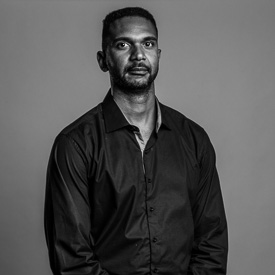

High-Boost:


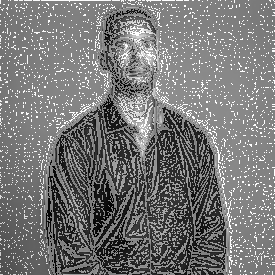

Filtro Passa-Alta (High-Pass):


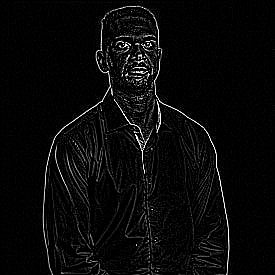

In [ ]:
import cv2
import numpy as np
from google.colab import files

# Função que implementa o filtro High-Boost.
# A = fator de amplificação (quanto maior, mais realce nas bordas)
def high_boost(img, A=1.5):
    # Aplica um desfoque gaussiano para obter a versão suavizada da imagem
    blur = cv2.GaussianBlur(img, (5,5), 0)

    # Máscara de detalhes = imagem original - imagem borrada
    mask = img - blur

    # High-boost = imagem original + (A - 1) * máscara
    # Se A = 1, vira só um filtro de nitidez leve
    # Se A > 1, acentua fortemente os detalhes
    hb = img + (A - 1) * mask

    # Garante que os valores fiquem entre 0 e 255.
    # Converte de volta para uint8.
    return np.clip(hb, 0, 255).astype(np.uint8)


# Função que aplica um filtro passa-alta clássico via convolução
def high_pass(img):
    # Kernel padrão de detecção de bordas (Laplaciano 8-neighbors)
    kernel = np.array([[ -1, -1, -1],
                       [ -1,  8, -1],
                       [ -1, -1, -1]])

    # Aplica a convolução na imagem
    return cv2.filter2D(img, -1, kernel)

print("Envie uma imagem:")
uploaded = files.upload()
filename = next(iter(uploaded.keys()))

img = cv2.imread(filename)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# ---------------- Aplicar filtros ---------------- #

hb_result = high_boost(gray, A=1.5)
hp_result = high_pass(gray)

# ---------------- Exibir resultados ---------------- #

print("Imagem original (tons de cinza):")
cv2_imshow(gray)

print("High-Boost:")
cv2_imshow(hb_result)

print("Filtro Passa-Alta (High-Pass):")
cv2_imshow(hp_result)


## 📌 4. Convolução Direta vs FFT
Implemente um programa que demonstre o ganho computacional obtido à partir da aplicação do conceito que envolve o Teorema da Convolução. O programa deverá exibir o tempo que a operação levou para ser aplicada à imagem usando o operador de convolução e exibir o tempo que aplicação do filtro levou para ser aplicada no contexto do domínio da frequência. Analise e teça comentários sobre os tempos obtidos.

Envie a imagem:


Saving WILL.jpg to WILL (4).jpg
Tempo convolução espacial: 0.000324 s
Tempo convolução via FFT:  0.015060 s
Resultado (convolução espacial):


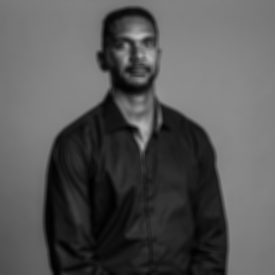

Resultado (FFT):


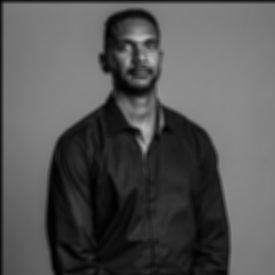

In [ ]:
import cv2
import numpy as np
import time
from google.colab import files
from google.colab.patches import cv2_imshow

# Mede o tempo da convolução tradicional (espacial) usando filter2D
def conv_time(img, kernel):
    # Marca o tempo inicial
    t0 = time.time()

    # Aplica convolução direta no domínio espacial
    r = cv2.filter2D(img, -1, kernel)

    # Retorna o resultado + o tempo gasto
    return r, time.time() - t0


# Mede o tempo da convolução usando FFT (domínio da frequência)
def fft_time(img, kernel):
    # Marca o tempo inicial
    t0 = time.time()

    # Dimensões da imagem
    h, w = img.shape[:2]

    # Dimensões do kernel
    kh, kw = kernel.shape

    # A convolução via FFT exige padding para evitar recorte circular
    # Altura e largura total após o zero-padding
    H = h + kh - 1
    W = w + kw - 1

    # Transformada de Fourier da imagem com padding
    F = np.fft.fft2(img, (H, W))

    # Transformada de Fourier do kernel com padding
    K = np.fft.fft2(kernel, (H, W))

    # Multiplicação ponto a ponto no domínio da frequência
    conv = np.fft.ifft2(F * K).real  # inversa → resultado da convolução

    # Remove o padding para voltar ao tamanho original da imagem
    conv = conv[:h, :w]

    # Retorna a convolução + tempo gasto
    # Converte para uint8 para visualização
    return conv.astype(np.uint8), time.time() - t0

print("Envie a imagem:")
uploaded = files.upload()
filename = next(iter(uploaded.keys()))

img = cv2.imread(filename)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# ---------------- Definir um kernel ---------------- #
# (Ex.: filtro suavizador 5x5)
kernel = np.ones((5,5), np.float32) / 25

# ---------------- Executar testes ---------------- #

conv_result, t_conv = conv_time(gray, kernel)
fft_result, t_fft = fft_time(gray, kernel)

# ---------------- Exibir resultados ---------------- #

print(f"Tempo convolução espacial: {t_conv:.6f} s")
print(f"Tempo convolução via FFT:  {t_fft:.6f} s")

print("Resultado (convolução espacial):")
cv2_imshow(conv_result)

print("Resultado (FFT):")
cv2_imshow(fft_result)

